# Cart-Pole with Actor Critic

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from IPython.display import clear_output
from itertools import count
from logger import Logger
from pyvirtualdisplay import Display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [3]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
############ HYPERPARAMETERS ##############
FRAMES = 2
RESIZE_PIXELS = 40

device = 'cuda:3'

POLICY_LR = 1e-5
Q_LR = 1e-5
GAMMA = 0.99
BETA = 0.01
END_SCORE = 1000
############################################

In [4]:
############ ENVIRONMENT ##############

class Environment:
    def __init__(self):
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        
        screen = self.env.render(mode='rgb_array').transpose((2,0,1))
        _, self.screen_height, self.screen_width = screen.shape
        
        self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(RESIZE_PIXELS, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])
        
        world_width = self.env.x_threshold * 2
        self.scale = self.screen_width / world_width
        
    def get_cart_location(self):
        return int(self.env.state[0] * self.scale + self.screen_width / 2.0)
        
    def get_screen(self):
        screen = self.env.render(mode='rgb_array').transpose((2, 0, 1))
        
        screen = screen[:, int(self.screen_height*0.4):int(self.screen_height * 0.8)]
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        return self.resize(screen).unsqueeze(0)
    
    def close(self):
        self.env.close()
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()

In [1]:
#### NETWORK ##############
'''
For policy gradient, the network should input the raw pixels, and output the probabilities of choosing either 0 or 1
'''

class PolicyNetwork(nn.Module):
    def __init__(self,h=60,w=135,device='cuda:0'):
        super().__init__()
        
        self.device = device
        
        input_channel = 2
        hidden_channel = 64
        hidden_channel2 = 32
        kernel_size = 5
        stride = 2
        
        self.base = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel2, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel2),
            nn.ReLU()
        )
        
        def conv2d_size_out(size, kernel_size = kernel_size, stride = stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * hidden_channel2
        
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )

    def forward(self, x):
        #x = x.to(self.device)
        x = self.base(x)
        x = x.flatten(1)
        x = self.head(x)
        return F.softmax(x,dim = 1)
    
class QNetwork(nn.Module):
    def __init__(self,h=60,w=135,device='cuda:0'):
        super().__init__()
        
        self.device = device
        
        input_channel = 2
        hidden_channel = 64
        hidden_channel2 = 32
        kernel_size = 5
        stride = 2
        
        self.base = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel2, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel2),
            nn.ReLU()
        )
        
        def conv2d_size_out(size, kernel_size = kernel_size, stride = stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * hidden_channel2
        
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )

    def forward(self, x):
        #x = x.to(self.device)
        x = self.base(x)
        x = x.flatten(1)
        x = self.head(x)
        return x

NameError: name 'nn' is not defined

In [6]:
env = Environment()
env.reset()

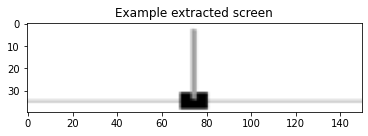

In [7]:
env.step(0)
plt.figure()
plt.imshow(env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy().squeeze(), cmap='gray')
plt.title('Example extracted screen')
plt.show()

In [8]:
screen_shape = env.get_screen().shape
policy_net = PolicyNetwork(h = screen_shape[2], w = screen_shape[3], device = device).to(device)

q_net = QNetwork(h = screen_shape[2], w = screen_shape[3], device = device).to(device)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=POLICY_LR)
q_optimizer = optim.Adam(q_net.parameters(), lr = Q_LR)

q_mse_loss = nn.MSELoss()

In [9]:
p_screen = env.get_screen().to(device)
c_screen = env.get_screen().to(device)

x = torch.cat((p_screen, c_screen),dim=1)

print("Policy Network output:",policy_net(x))
print("Q Network output:", q_net(x))

tensor([[0.5471, 0.4529]], device='cuda:3', grad_fn=<SoftmaxBackward>)

In [10]:
HISTORY = []

def discount_rewards(r):
    discounted_r = torch.zeros(r.size())
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * GAMMA + r[t]
        discounted_r[t] = running_add

    return discounted_r

def run_episode(net, episode, env, logger = None):
    net.eval()
    state = env.reset()
    prev_screen = env.get_screen().to(device)
    
    reward_sum = 0
    xs = torch.FloatTensor([]).to(device)
    ys = torch.FloatTensor([]).to(device)
    rewards = torch.FloatTensor([]).to(device)
    steps = 0

    for t in count():
        screen = env.get_screen().to(device)
        
        x = torch.cat((prev_screen, screen), dim=1)
        
        action_prob = net(x)

        action = 0 if random.random() < action_prob[0][0] else 1

        y = torch.FloatTensor([[1, 0]] if action == 0 else [[0, 1]]).to(device)
        
        xs = torch.cat([xs, x])
        ys = torch.cat([ys, y])
        
        prev_screen = screen
        state, reward, done, _ = env.step(action)
        
        rewards = torch.cat([rewards, torch.FloatTensor([[reward]]).to(device)])
        reward_sum += reward
        steps += 1
    

        if done or steps >= 1000:
            adv = discount_rewards(rewards)
            #adv = (adv - adv.mean())
            adv = (adv - adv.mean())/(adv.std() + 1e-7)
            loss,entropy = learn(xs, ys, adv, net)
            print("[Episode {:>5}]  steps: {:>5} loss: {:>5} entropy: {:>5}".format(episode, steps, loss, entropy))
            if logger != None:
                log.log_scalar(scalar=steps,episode=episode,name='duration')
                log.log_scalar(scalar=reward_sum,episode=episode,name='reward')
                log.log_scalar(scalar=entropy,episode=episode,name='entropy')
                log.log_scalar(scalar=loss,episode=episode,name='loss')
            return False

def learn(x, y, adv, model):
    model.train()
    # Loss function, ∑ Ai*logp(yi∣xi), but we need fake lable Y due to autodiff
    action_pred = model(x)
    log_action_pred = torch.log(action_pred)
    
    entropy = -torch.sum(action_pred*log_action_pred,dim=1).mean()
    
    y = Variable(y, requires_grad=True)
    adv = Variable(adv).to(device)
    log_lik = -y * log_action_pred
    # print(y)
    log_lik_adv = log_lik * adv
    loss = torch.sum(log_lik_adv, 1).mean() - BETA*entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), entropy.item()

def update_q(prev_state, prev_action, reward, state, q_net, policy_net, loss_function, optimizer):
    
    # q_net(s,a) = q_net(s,a) - lr * (reward + gamma * (q_net(s',a) @ policy_net(s')) - q_net(s,a))
    
    q_prev = q_net(prev_state)@prev_action
    q = q_net(state).detach()
    action_prob = policy_net(state).detach()
    
    loss = loss_function(q_prev,(reward + GAMMA*(q@action_prob)))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

def update_policy(state, action, reward, q_net, policy_net, optimizer):
    
    # policy_net = policy_net - lr * delta(log(policy_net) * (q_net(s,a) - q_net(s) @ policy_net(s)))
    
    action_prob = policy_net(state)
    q = q_net(state).detach()
    
    q_policy = q@action_prob.detach()
    q_actual = q@action
    
    adv = q_action - q_policy
    log_action_prob = torch.log(action_prob)
    log_lik = -action@log_action_prob
    log_lik_adv = log_lik * adv
    
    entropy = -torch.sum(action_prob*action_prob,dim=1).mean()
    
    loss = log_lik_adv - BETA*entropy
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.item()

In [11]:
name = f"AC hidden=64 lr={LR} max_steps=1000 Adam fullwidth BETA={BETA}"
#name = "test"
log = Logger(model_name=name)

In [ ]:
import time

for episode in count()
    complete = run_episode(policy_net, episode, env,log)

    if complete:
        print('complete...!')
        break
    
    if episode % 50 == 0:
        clear_output(wait=True)
        torch.save(policy_net.state_dict(), f'models/{name}.pt')

[Episode 10451]  steps:    88 loss: -0.16389600932598114 entropy: 0.519363522529602
[Episode 10452]  steps:    67 loss: -0.08535914868116379 entropy: 0.4573885202407837
[Episode 10453]  steps:    74 loss: -0.04664262756705284 entropy: 0.5364887118339539
[Episode 10454]  steps:    79 loss: -0.10459451377391815 entropy: 0.5561109781265259
[Episode 10455]  steps:   177 loss: -0.0721498653292656 entropy: 0.5211411714553833
[Episode 10456]  steps:    71 loss: -0.10105814039707184 entropy: 0.5731703042984009
[Episode 10457]  steps:   103 loss: -0.059668444097042084 entropy: 0.5462737083435059
[Episode 10458]  steps:    82 loss: -0.06550679355859756 entropy: 0.5116916298866272
[Episode 10459]  steps:   186 loss: -0.022856153547763824 entropy: 0.5126659274101257
[Episode 10460]  steps:    88 loss: -0.026433883234858513 entropy: 0.5210526585578918
[Episode 10461]  steps:   142 loss: -0.06276030838489532 entropy: 0.5520593523979187
[Episode 10462]  steps:    92 loss: -0.09456738084554672 entropy